# Online critic

#### Imports

In [1]:
from abc import ABC, abstractmethod
from itertools import pairwise

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn
import torch.optim as optim
from kilroyplot.plot import plt
from torch.distributions.categorical import Categorical
import einops as ein

#### Configuration

In [2]:
start_word, stop_word, pad_word = 1, 2, 0
vocab_size = max(4, 10)
max_length = 5
embedding_dim, hidden_dim, out_dim = 16, 16, vocab_size
n_times = 10
epochs = 2000
external_sample_size = 20
internal_sample_size = 200
buffer_length = 1000

#### Seeding

In [3]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

#### Utilities

In [4]:
def squash_packed(x, fn):
    return rnn.PackedSequence(
        fn(x.data), x.batch_sizes, x.sorted_indices, x.unsorted_indices
    )


def unpad_sequence(x, lengths):
    return [s[:length] for s, length in zip(x, lengths)]

#### Reward function

In [5]:
class RewardFunction(ABC):
    @abstractmethod
    def __call__(self, x):
        pass

In [6]:
class ZigzagRewardFunction(RewardFunction):
    def __init__(self, vocab_size, max_length):
        self._vocab_size = vocab_size
        self._max_length = max_length

    def _score(self, x):
        maximum = (self._vocab_size - 1) * (self._max_length - 1)
        return sum([np.abs(b - a) for a, b in pairwise(x)]) / maximum

    def __call__(self, x):
        sequences = rnn.unpack_sequence(x)
        scores = [torch.tensor([[self._score(s)]] * len(s)) for s in sequences]
        return rnn.pack_sequence(scores, enforce_sorted=False)

In [7]:
reward_function = ZigzagRewardFunction(vocab_size, max_length)

#### Critic

In [8]:
class Critic(nn.Module, RewardFunction):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        is_packed = isinstance(x, rnn.PackedSequence)
        x = (
            squash_packed(x, self.embedding)
            if is_packed
            else self.embedding(x)
        )
        ht, _ = self.lstm(x)
        return squash_packed(ht, self.linear) if is_packed else self.linear(ht)

#### Policy

In [9]:
class Policy(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        is_packed = isinstance(x, rnn.PackedSequence)
        x = (
            squash_packed(x, self.embedding)
            if is_packed
            else self.embedding(x)
        )
        out, _ = self.lstm(x)
        y = squash_packed(out, self.linear) if is_packed else self.linear(out)
        return (
            squash_packed(y, lambda yf: F.log_softmax(yf, dim=-1))
            if is_packed
            else F.log_softmax(y, dim=-1)
        )

In [10]:
class Generator:
    def __init__(self, model, start_word, end_word, pad_word, max_length):
        self.model = model
        self.start_word = start_word
        self.end_word = end_word
        self.pad_word = pad_word
        self.max_length = max_length

    def generate(self, n=1):
        out = []
        x = torch.tensor([[self.start_word]] * n)
        i = 1
        while len(x) > 0 and i < self.max_length:
            batched_logprobs = self.model(x)[:, -1]
            next_words = self.pick_words(batched_logprobs)
            x = torch.cat((x, next_words.unsqueeze(-1)), dim=-1)
            finished_mask = next_words == self.end_word
            finished = x[finished_mask]
            out.extend(list(finished))
            x = x[~finished_mask]
            i += 1
        out.extend(list(x))
        out = sorted(out, key=lambda s: len(s), reverse=True)
        lengths = [len(s) for s in out]
        out = rnn.pad_sequence(
            out, batch_first=True, padding_value=self.pad_word
        )
        return rnn.pack_padded_sequence(out, lengths, batch_first=True)

    def pick_words(self, batched_logprobs):
        return torch.tensor(
            [
                Categorical(logprobs.exp()).sample()
                for logprobs in batched_logprobs
            ]
        )

#### Loss function

In [11]:
class LossFunction:
    def __call__(self, logprobs, sentences, rewards):
        logprobs = rnn.unpack_sequence(logprobs)
        sentences = rnn.unpack_sequence(sentences)
        rewards = rnn.unpack_sequence(rewards)
        logprobs = [
            torch.gather(p[:-1], -1, s[1:].unsqueeze(-1)).squeeze(-1)
            for s, p in zip(sentences, logprobs)
        ]
        loss = torch.stack(
            [-(r[1:].flatten() * p).mean() for p, r in zip(logprobs, rewards)]
        )
        return loss.mean()

In [12]:
loss_function = LossFunction()

#### Training

In [13]:
class TrainIterationFunction(ABC):
    @abstractmethod
    def __call__(
        policy,
        generator,
        sample_size,
        optimizer,
        reward_function,
        loss_function,
        pad_word,
    ):
        pass

In [14]:
class BaseTrainIterationFunction(TrainIterationFunction):
    def __call__(
        self,
        policy,
        generator,
        sample_size,
        optimizer,
        reward_function,
        loss_function,
        pad_word,
    ):
        optimizer.zero_grad()
        sentences = generator.generate(sample_size)
        rewards = reward_function(sentences)
        logprobs = policy(sentences)
        loss = loss_function(logprobs, sentences, rewards)
        loss.backward()
        optimizer.step()
        return (
            loss.item(),
            torch.stack([r.mean() for r in rnn.unpack_sequence(rewards)])
            .mean()
            .item(),
        )

In [15]:
class CriticTrainIterationFunction(TrainIterationFunction):
    def __init__(self, critic, lr, sample_size, buffer_length):
        self._critic = critic
        self._optimizer = optim.SGD(critic.parameters(), lr=lr)
        self._sample_size = sample_size
        self._buffer = []
        self._buffer_length = buffer_length

    def __call__(
        self,
        policy,
        generator,
        sample_size,
        optimizer,
        reward_function,
        loss_function,
        pad_word,
    ):
        sentences = generator.generate(sample_size)
        evaluation_rewards = reward_function(sentences)
        for sentence in rnn.unpack_sequence(sentences):
            self._buffer.append(sentence)
            if len(self._buffer) > self._buffer_length:
                self._buffer.pop(0)

        sentences = rnn.pack_sequence(self._buffer, enforce_sorted=False)

        self._optimizer.zero_grad()
        real_rewards = reward_function(sentences)
        predicted_rewards = self._critic(sentences)
        loss = F.mse_loss(predicted_rewards.data, real_rewards.data)
        loss.backward()
        self._optimizer.step()

        optimizer.zero_grad()
        sentences = generator.generate(self._sample_size)
        rewards = self._critic(sentences)

        rewards = rnn.pack_sequence(
            [r - r[0] for r in rnn.unpack_sequence(rewards)]
        )

        logprobs = policy(sentences)
        loss = loss_function(logprobs, sentences, rewards)
        loss.backward()
        optimizer.step()

        return (
            loss.item(),
            torch.stack(
                [r.mean() for r in rnn.unpack_sequence(evaluation_rewards)]
            )
            .mean()
            .item(),
        )

In [16]:
def train(
    policy,
    generator,
    epochs,
    sample_size,
    optimizer,
    reward_function,
    train_iteration_function,
    loss_function,
    pad_word,
):
    losses, rewards = [], []
    for i in range(epochs):
        loss, reward = train_iteration_function(
            policy,
            generator,
            sample_size,
            optimizer,
            reward_function,
            loss_function,
            pad_word,
        )
        losses.append(loss)
        rewards.append(reward)
    return torch.tensor(losses), torch.tensor(rewards)

In [17]:
def run_base(
    n_times,
    vocab_size,
    embedding_dim,
    hidden_dim,
    out_dim,
    start_word,
    stop_word,
    pad_word,
    max_length,
    epochs,
    sample_size,
    lr,
    reward_function,
    loss_function,
):
    rewards = []
    for i in range(n_times):
        policy = Policy(vocab_size, embedding_dim, hidden_dim, out_dim)
        generator = Generator(
            policy, start_word, stop_word, pad_word, max_length
        )
        optimizer = optim.SGD(policy.parameters(), lr=lr)
        _, r = train(
            policy,
            generator,
            epochs,
            sample_size,
            optimizer,
            reward_function,
            BaseTrainIterationFunction(),
            loss_function,
            pad_word,
        )
        rewards.append(r)
    return torch.stack(rewards)

In [18]:
def run_critic(
    n_times,
    vocab_size,
    embedding_dim,
    hidden_dim,
    out_dim,
    start_word,
    stop_word,
    pad_word,
    max_length,
    epochs,
    external_sample_size,
    internal_sample_size,
    buffer_length,
    policy_lr,
    critic_lr,
    reward_function,
    loss_function,
):
    rewards = []
    for i in range(n_times):
        policy = Policy(vocab_size, embedding_dim, hidden_dim, out_dim)
        critic = Critic(vocab_size, embedding_dim, hidden_dim)
        generator = Generator(
            policy, start_word, stop_word, pad_word, max_length
        )
        optimizer = optim.SGD(policy.parameters(), lr=policy_lr)
        _, r = train(
            policy,
            generator,
            epochs,
            external_sample_size,
            optimizer,
            reward_function,
            CriticTrainIterationFunction(
                critic, critic_lr, internal_sample_size, buffer_length
            ),
            loss_function,
            pad_word,
        )
        rewards.append(r)
    return torch.stack(rewards)

In [19]:
rewards_base = run_base(
    n_times,
    vocab_size,
    embedding_dim,
    hidden_dim,
    out_dim,
    start_word,
    stop_word,
    pad_word,
    max_length,
    epochs,
    external_sample_size,
    0.3,
    reward_function,
    loss_function,
)

In [20]:
rewards_critic = run_critic(
    n_times,
    vocab_size,
    embedding_dim,
    hidden_dim,
    out_dim,
    start_word,
    stop_word,
    pad_word,
    max_length,
    epochs,
    external_sample_size,
    internal_sample_size,
    buffer_length,
    0.3,
    0.1,
    reward_function,
    loss_function,
)

#### Results

In [21]:
def plot_rewards(
    rewards, label, x_label="Iteration", y_label="Reward", alpha=0.5
):
    rewards = ein.rearrange(rewards, "n t -> t n")
    median = rewards.median(dim=1).values
    lower, upper = np.percentile(rewards, [25, 75], axis=1)
    plt.plot(median, label=label)
    plt.fill_between(range(len(median)), lower, upper, alpha=alpha)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()

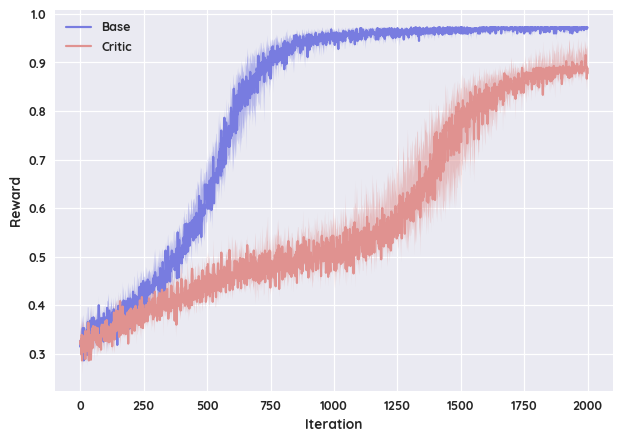

In [22]:
plot_rewards(rewards_base, "Base")
plot_rewards(rewards_critic, "Critic")